# Time Series Analysis: Energy Consumption Prediction

## 1. Load Dataset

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load dataset
df = pd.read_csv('data/PJME_hourly.csv')
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [3]:
# set index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


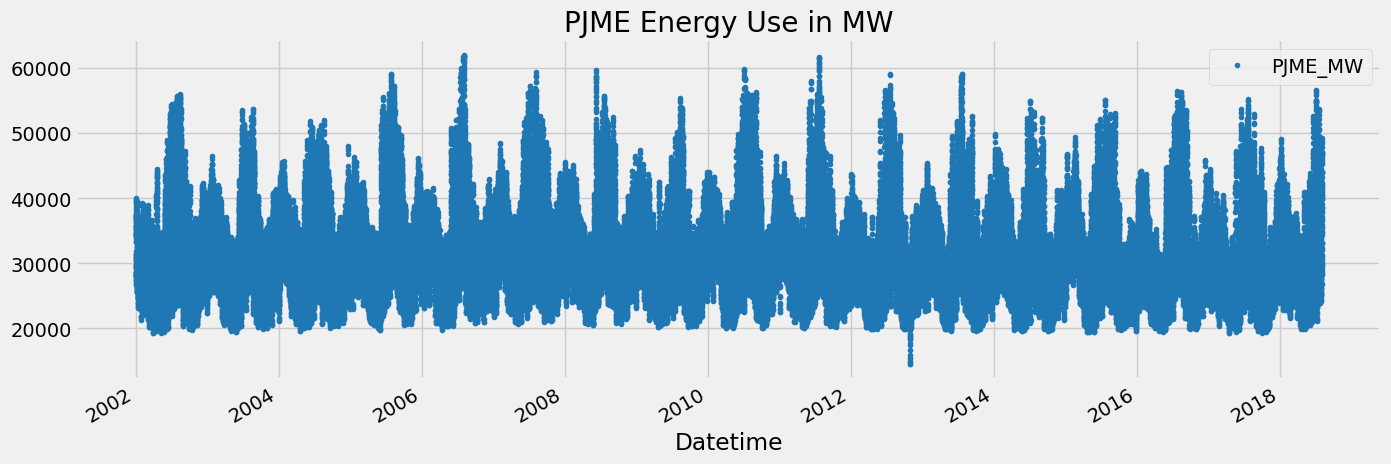

In [4]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df.plot(style='.', 
        figsize=(15,5), 
        color = color_pal[0], 
        title='PJME Energy Use in MW')

plt.show()

## 2. Split Train / Test Set

In [5]:
# Split data into training and test set
train = df.loc[df.index <'2015-01-01']
test = df.loc[df.index >='2015-01-01']

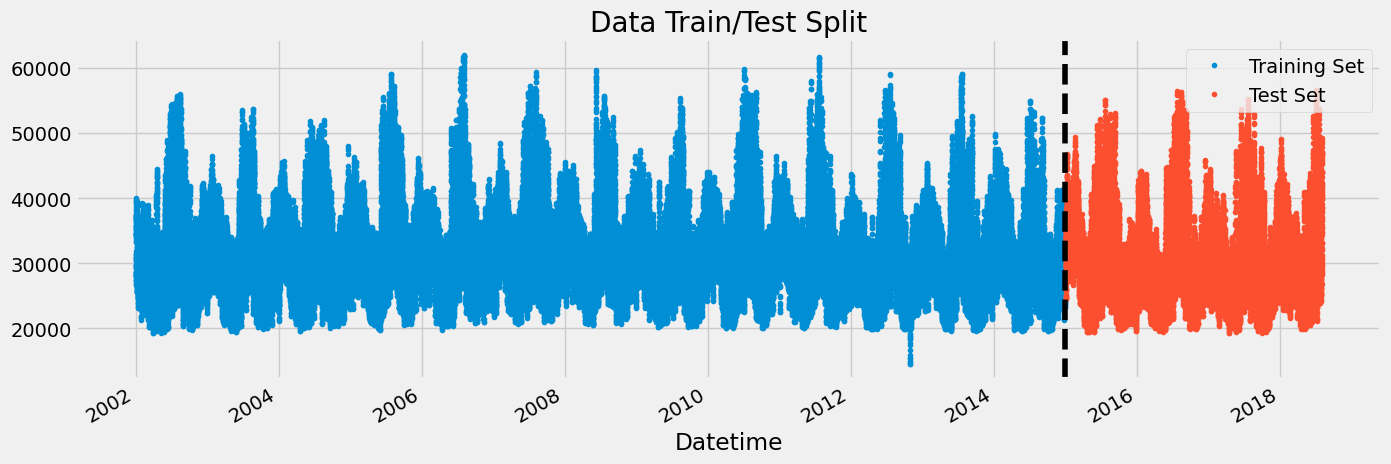

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', style='.')
test.plot(ax=ax, label='Test Set', style='.')
ax.axvline('2015-01-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

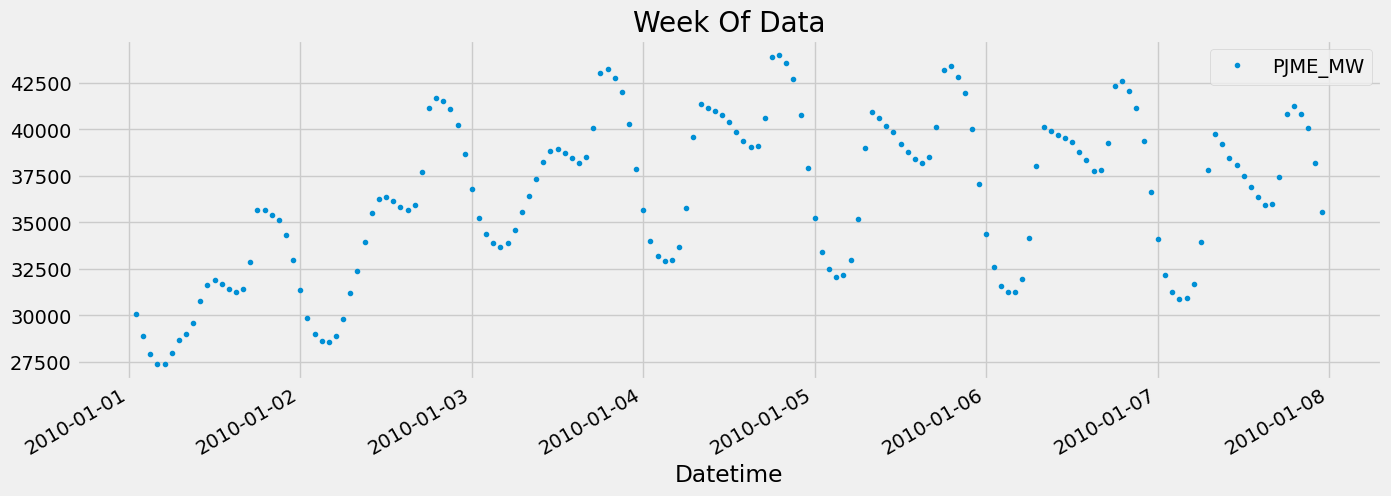

In [7]:
df.loc[(df.index > '2010-01-01') & (df.index < '2010-01-08')].plot(figsize=(15, 5), title='Week Of Data', style='.')
plt.show()

## 3. Create Features

In [8]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

## 4. Visualize Feature / Target Relationship

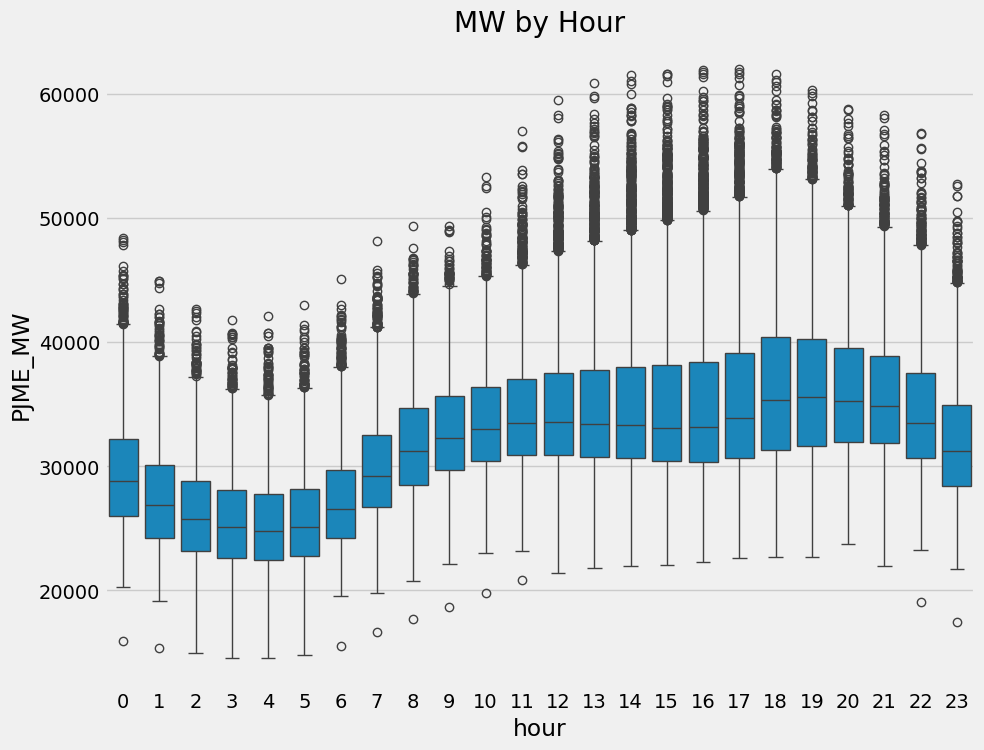

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

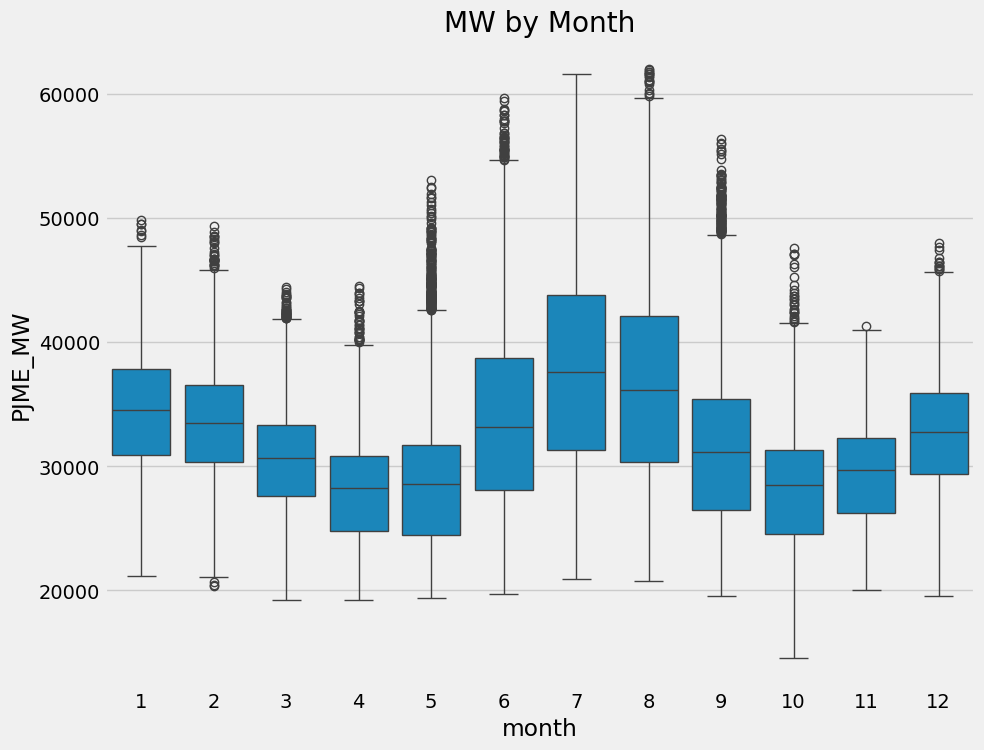

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by Month')
plt.show()

## 6. Create Model

In [11]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [12]:
train = create_features(train)
test = create_features(test)

In [13]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [14]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [15]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [16]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.01)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],  
        verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## 7. Feature Importance

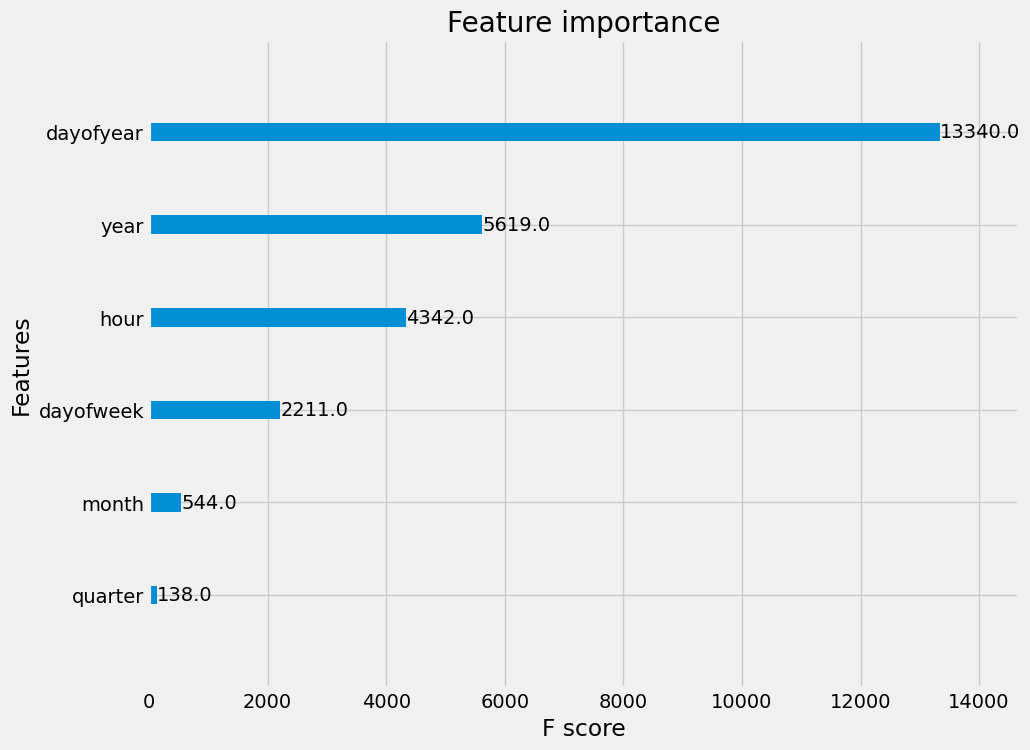

In [17]:
# plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(reg, ax=ax)
plt.show()

## 9. Forecast on Test Set

In [18]:
test['prediction'] = reg.predict(X_test)

In [21]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [22]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,NaN
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,38623.246094
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,38495.484375
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,36229.527344


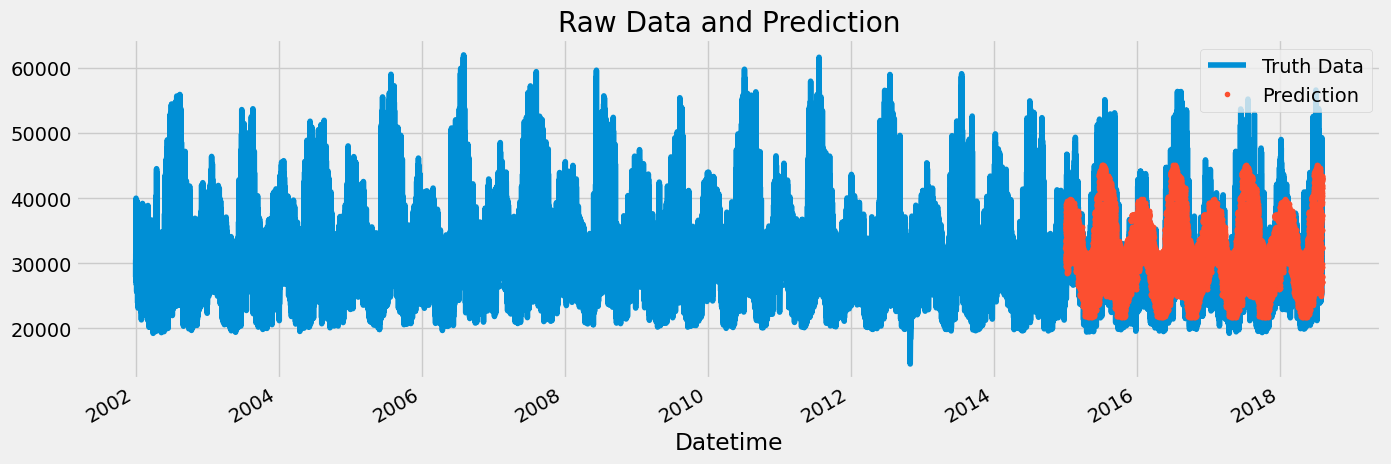

In [23]:
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

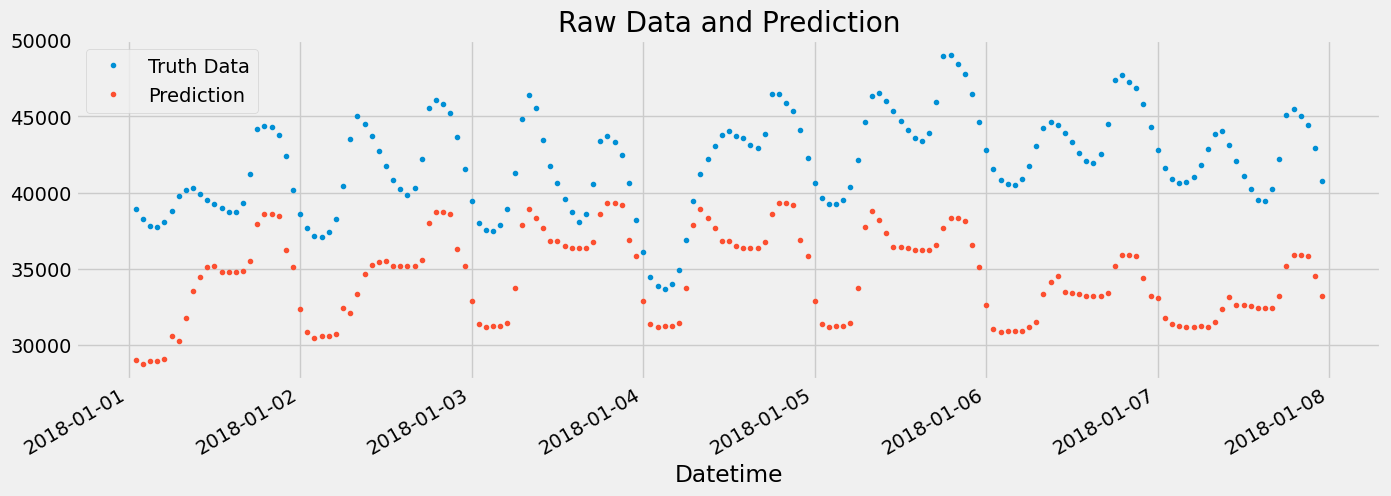

In [26]:
ax = df.loc[(df.index > '2018-01-01') & (df.index < '2018-01-08'), ['PJME_MW']].plot(figsize=(15, 5), style='.')
df.loc[(df.index > '2018-01-01') & (df.index < '2018-01-08'), ['prediction']].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [28]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE: {score}')

RMSE: 3741.030178837441


## 10. Calculate Error

In [29]:
test['error'] = np.abs(test['PJME_MW'] - test['prediction'])

In [30]:
test['date'] = test.index.date

In [31]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

In [32]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64